In [1]:
#本章需导入的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings(action = 'ignore')
from sklearn.metrics import confusion_matrix,f1_score,roc_curve, auc, precision_recall_curve,accuracy_score
from sklearn.model_selection import train_test_split,KFold,LeaveOneOut,LeavePOut # 数据集划分方法
from sklearn.model_selection import cross_val_score,cross_validate # 计算交叉验证下的测试误差
from sklearn import preprocessing
import sklearn.linear_model as LM
from sklearn import neighbors

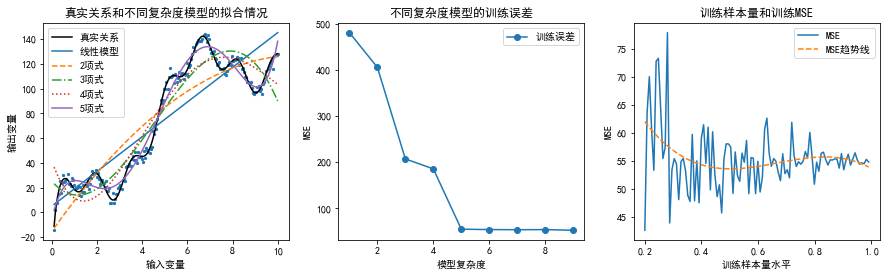

In [2]:
np.random.seed(123)
N=200
x=np.linspace(0.1,10, num=N)
y=[]
z=[]
for i in range(N):
    tmp=10*np.math.sin(4*x[i])+10*x[i]+20*np.math.log(x[i])+30*np.math.cos(x[i])
    y.append(tmp)
    tmp=y[i]+np.random.normal(0,3)
    z.append(tmp)

fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(15,4))
axes[0].scatter(x,z,s=5)
axes[0].plot(x,y,'k-',label="真实关系")

modelLR=LM.LinearRegression()
X=x.reshape(N,1)
Y=np.array(z)
modelLR.fit(X,Y)
axes[0].plot(x,modelLR.predict(X),label="线性模型")
linestyle=['--','-.',':','-']
for i in np.arange(1,5):
    tmp=pow(x,(i+1)).reshape(N,1)
    X=np.hstack((X,tmp))
    modelLR.fit(X,Y)
    axes[0].plot(x,modelLR.predict(X),linestyle=linestyle[i-1],label=str(i+1)+"项式")
axes[0].legend()
axes[0].set_title("真实关系和不同复杂度模型的拟合情况")
axes[0].set_xlabel("输入变量")
axes[0].set_ylabel("输出变量")

X=x.reshape(N,1)
Y=np.array(z)
modelLR.fit(X,Y)
MSEtrain=[np.sum((Y-modelLR.predict(X))**2)/(N-2)]
for i in np.arange(1,9):  
    tmp=pow(x,(i+1)).reshape(N,1)
    X=np.hstack((X,tmp))
    modelLR.fit(X,Y)
    MSEtrain.append(np.sum((Y-modelLR.predict(X))**2)/(N-(i+2)))
axes[1].plot(np.arange(1,10),MSEtrain,marker='o',label='训练误差')
axes[1].legend()
axes[1].set_title("不同复杂度模型的训练误差")
axes[1].set_xlabel("模型复杂度")
axes[1].set_ylabel("MSE")    

X=x.reshape(N,1)
Y=np.array(z)
for i in np.arange(1,5):  #采用5项式模型
    tmp=pow(x,(i+1)).reshape(N,1)
    X=np.hstack((X,tmp))    
np.random.seed(0)
size=np.linspace(0.2,0.99,100)
MSEtrain=[]
for i in range(len(size)):
    Ntraining=int(N*size[i])
    id=np.random.choice(N,Ntraining,replace=False)
    X_train=X[id]
    y_train=Y[id]
    modelLR.fit(X_train,y_train)
    MSEtrain.append(np.sum((y_train-modelLR.predict(X_train))**2)/(Ntraining-6))    

tmpx=np.linspace(1,len(size), num=len(size)).reshape(len(size),1)  #拟合MSE
tmpX=np.hstack((tmpx,tmpx**2))
tmpX=np.hstack((tmpX,tmpx**3))
modelLR.fit(tmpX,MSEtrain)

axes[2].plot(size,MSEtrain,linewidth=1.5,linestyle='-',label='MSE')
axes[2].plot(size,modelLR.predict(tmpX),linewidth=1.5,linestyle='--',label='MSE趋势线')
axes[2].set_title("训练样本量和训练MSE")
axes[2].set_xlabel("训练样本量水平")
axes[2].set_ylabel("MSE")
axes[2].legend()
plt.show()

说明：
1、这里通过数据模拟直观展示模型复杂度和训练误差的关系。随模型复杂度的提高，训练误差单调下降。
2、首先设定输入变量和输出变量的真实关系，并通过加上服从正态分布的随机数模拟其他随机因素对输出变量的影响。这里，设定的真实关系函数可以被泰勒展开，因此一定是次数越高的多项式模型越贴近真实观测值。 到达一定阶数（这里为9）后继续增加阶数对参数估计结果的影响很小可以忽略，无需再增加阶数。
3、分别建立各个多项式模型。这里消除了模型复杂度本身导致对MSE计算结果的影响，MSE计算时分母为自由度：样本量-(输入变量个数+1)。
4、考察训练集样本量对对于特定模型（这里为五项式）学习充分性的影响。样本量依次为原数据集的20%至99%。这里消除了样本量本身对MSE计算结果的影响，MSE计算时分母为自由度：样本量-(输入变量个数+1)。对不同样本量下的MSE进行三次曲线拟合。

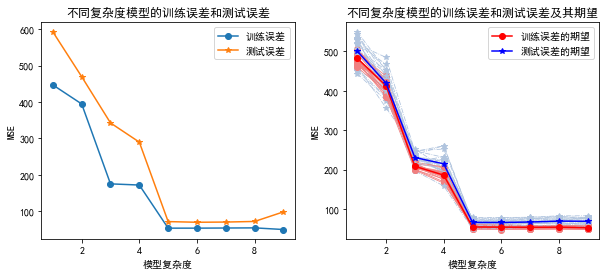

In [3]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,4))  
modelLR=LM.LinearRegression()

np.random.seed(123)
Ntraining=int(N*0.7)
Ntest=int(N*0.3)
id=np.random.choice(N,Ntraining,replace=False)
X_train=x[id].reshape(Ntraining,1)
y_train=np.array(z)[id].reshape(Ntraining,1)
modelLR.fit(X_train,y_train)
MSEtrain=[np.sum((y_train-modelLR.predict(X_train))**2)/(Ntraining-2)]

xtest= np.delete(x, id).reshape(Ntest,1)
X_test= np.delete(x, id).reshape(Ntest,1)
y_test=np.delete(z,id).reshape(Ntest,1)
MSEtest=[np.sum((y_test-modelLR.predict(X_test))**2)/(Ntest-2)]

for i in np.arange(1,9):
    tmp=pow(x[id],(i+1)).reshape(Ntraining,1)
    X_train=np.hstack((X_train,tmp))
    modelLR.fit(X_train,y_train)
    MSEtrain.append(np.sum((y_train-modelLR.predict(X_train))**2)/(Ntraining-(i+2)))
    tmp=pow(xtest,(i+1)).reshape(Ntest,1)    
    X_test=np.hstack((X_test,tmp))
    MSEtest.append(np.sum((y_test-modelLR.predict(X_test))**2)/(Ntest-(i+2)))

axes[0].plot(np.arange(1,10,1),MSEtrain,marker='o',label='训练误差')
axes[0].plot(np.arange(1,10,1),MSEtest,marker='*',label='测试误差')
axes[0].legend()
axes[0].set_title("不同复杂度模型的训练误差和测试误差")
axes[0].set_xlabel("模型复杂度")
axes[0].set_ylabel("MSE")

MSEtrain=[]
MSEtest=[]
for j in range(20):
    x=np.linspace(0.1,10, num=N)
    id=np.random.choice(N,Ntraining,replace=False)
    X_train=x[id].reshape(Ntraining,1)
    y_train=np.array(z)[id].reshape(Ntraining,1)
    modelLR.fit(X_train,y_train)
    mse_train=[np.sum((y_train-modelLR.predict(X_train))**2)/(Ntraining-2)]

    xtest= np.delete(x, id).reshape(Ntest,1)
    X_test= np.delete(x, id).reshape(Ntest,1)
    y_test=np.delete(z,id).reshape(Ntest,1)
    mse_test=[np.sum((y_test-modelLR.predict(X_test))**2)/(Ntest-2)]

    for i in np.arange(1,9):
        tmp=pow(x[id],(i+1)).reshape(Ntraining,1)
        X_train=np.hstack((X_train,tmp))
        modelLR.fit(X_train,y_train)
        mse_train.append(np.sum((y_train-modelLR.predict(X_train))**2)/(Ntraining-(i+2)))
        tmp=pow(xtest,(i+1)).reshape(Ntest,1)    
        X_test=np.hstack((X_test,tmp))
        mse_test.append(np.sum((y_test-modelLR.predict(X_test))**2)/(Ntest-(i+2)))
    plt.plot(np.arange(1,10),mse_train,marker='o',linewidth=0.8,c='lightcoral',linestyle='-')
    plt.plot(np.arange(1,10),mse_test,marker='*',linewidth=0.8,c='lightsteelblue',linestyle='-.')
    MSEtrain.append(mse_train)
    MSEtest.append(mse_test)
    
MSETrain=pd.DataFrame(MSEtrain)
MSETest=pd.DataFrame(MSEtest)
axes[1].plot(np.arange(1,10),MSETrain.mean(),marker='o',linewidth=1.5,c='red',linestyle='-',label="训练误差的期望")
axes[1].plot(np.arange(1,10),MSETest.mean(),marker='*',linewidth=1.5,c='blue',linestyle='-',label="测试误差的期望")
axes[1].set_title("不同复杂度模型的训练误差和测试误差及其期望")
axes[1].set_xlabel("模型复杂度")
axes[1].set_ylabel("MSE")
axes[1].legend()
plt.show()

说明：
1、这里通过数据模拟直观展示不同复杂度模型下训练误差和测试误差的关系。随模型复杂度的提高，训练误差单调下降，测试误差呈先下降后来上升的U字形。
2、从数据集中随机抽取一定比例的样本观测组成训练集训练模型，剩余的样本观测组成测试集计算测试误差。这里进行了20次。
3、样本观测的随机抽取必然导致20个训练集包含可能不同的样本观测，由此模型的参数估计值会有差别，从而使得20个训练误差和测试误差的数值结果不尽相等。带圆点的浅红色和浅灰色分别对应20次抽样的训练误差和测试误差，它们各自的均值对应带星号的红色和蓝色线。
